# Ridge regression and Dummy coding
This notebook demonstrates why we have to be careful about what type of dummy coding to choose when we use Ridge regression to estimate a linear model. Without Regularization, we usually do not introduce redundant (linear dependent) regressors, as it makes the estimation unstable. As you will see, when using Ridge regression, the choice of dummy coding can have unintended consequences.

## The example
Consider the simple example, where you measured some data (y) for individuals that belong to three groups, each one containing N=5 observations. I know, I know, this is a criminally low sample size, but it is simply an illustrative example, and what you see here also holds in large data sets, both with balanced and unbalanced designs. 

In [2]:
# Preliminaries
import numpy as np
import pandas as pd 
import sklearn as sk
from sklearn.linear_model import LinearRegression, Ridge
import seaborn as sb 
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='group', ylabel='y'>

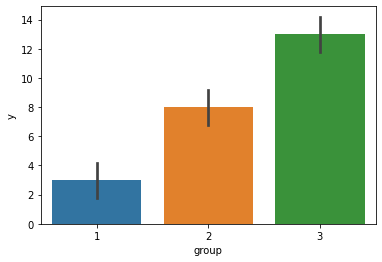

In [3]:
# Let's make an example where group 1 has mean 3 and the other two groups mean 8.
D=pd.DataFrame({'group':[1,1,1,1,1,2,2,2,2,2,3,3,3,3,3],'y':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]})
sb.barplot(data=D,x='group',y='y')

In [4]:
# Now let's dummy code the group in four different ways 
X = pd.get_dummies(D['group'],drop_first=False).values # Full dummy code with a dummy variable for each group 
X1 = X[:,1:3]   # Drop the first group 
X2 = X[:,[0,2]] # Drop the second group 
X3 = X[:,:2]    # Drop the last group 

In [5]:
# For each coding scheme, let's also get a matrix that allows us to predict the 3 group means 
Xpred  = X[[0,5,11],:]
Xpred1 = X1[[0,5,11],:]
Xpred2 = X2[[0,5,11],:]
Xpred3 = X3[[0,5,11],:]

In [6]:
# When using ordinary least-squares, it does not matter which coding you use - you always get the group mean exactly.  
# You can even use the full dummy coded variable, although this makes the variance of the regression coefficients infinite. 
OLS = LinearRegression().fit(X1,D['y'])
ypred_OLS=OLS.predict(Xpred1)
ypred_OLS

array([ 3.,  8., 13.])

In [7]:
# Now let's use the different dummy coding schemes for Ridge regression, using a Ridge coefficient of 1
# First the first one: 
R1 = Ridge(alpha = 1)
R1.fit(X1,D['y'])
ypred_R1=R1.predict(Xpred1)
ypred_R1

array([ 4.875     ,  7.47916667, 11.64583333])

In [8]:
# Then dropping the middle group  
R2 = Ridge(alpha = 1)
R2.fit(X2,D['y'])
ypred_R2=R2.predict(Xpred2)
ypred_R2

array([ 3.83333333,  8.        , 12.16666667])

In [9]:
# And finally dropping the third group
R3 = Ridge(alpha = 1)
R3.fit(X3,D['y'])
ypred_R3=R3.predict(Xpred3)
ypred_R3

array([ 4.35416667,  8.52083333, 11.125     ])

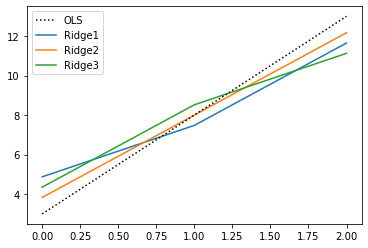

In [10]:
# Now let's plot the different predicted groups means, 
# An in comparision show 

h1 = plt.plot([0,1,2],np.c_[ypred_R1,ypred_R2,ypred_R3])
h2 = plt.plot([0,1,2],ypred_OLS,'k:')
plt.legend(h2+h1,('OLS','Ridge1','Ridge2','Ridge3'))

As we can see, the different ways of dummy coding induce different predicted values. The predicted groups means are usually "shrunken" towards the overall mean of the data. However, depending on coding scheme this can happen to various degrees, and for the middle group in different directions! 

## What is going on? 
To understand how this behavior comes about (and how to fix it), it is useful to understand Ridge regression as estimating the best linear unbiased predictor (BLUP) for the following mixed effects model (Robinson, 1991).

$$ \mathbf{y} = \mathbf{X} \beta +\mathbf{Zu}+ \boldsymbol{\epsilon} $$

In this case, $\mathbf{X}$ is just a columns of 1s and $\beta$ is the intercept. $\mathbf{Z}$ is the design matrix that encodes the $q$ random effects. The coefficients for the random effects, $\mathbf{u}$, are assumed to the normally distributed with $N(\mathbf{0},\mathbf{I_q}\sigma^2$). That is, the multliple regressions coefficients are assumed to have the same variance $\sigma^2$, and are independent from each other. The noise $\epsilon$ is assumed to have normal distribution with $N(\mathbf{0},\mathbf{I_N}\sigma_{\epsilon}^2)$. 

In this situation, Ridge regression is the BLUP estimator if we set the ridge parameter to 
$\lambda = \sigma_{\epsilon}^2 / \sigma^2$. In other words, the optimal regularization is low when the noise is low and the true effects are large - the optimal regularization is high when the noise is high and the true effects are small. 

Sklearns ridge regression first removes the mean from $\mathbf{y}$ and $\mathbf{Z}$

$$ \tilde{\mathbf{y}} = \mathbf{y}- \mathbf{X}(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$$ 
$$ \tilde{\mathbf{Z}} = \mathbf{Z}- \mathbf{X}(\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{Z}$$ 

And then estimates the coefficients for the random effects with 

$$ \hat{\mathbf{u}} = (\tilde{\mathbf{Z}}^T  \tilde{\mathbf{Z}} + \mathbf{I}_N \lambda)^{-1} \tilde{\mathbf{Z}}^T \mathbf{y}$$ 

So Ridge regression leads to the BLUP estimate, if we assume that the variance of the data, conditioned on the overall mean, is: 

$$ var(\mathbf{y} | \beta) = \mathbf{Z} \mathbf{Z}^T \sigma^2 + \mathbf{I}_N \sigma_{\epsilon}^2$$

As we will see below, the 3 different ways of dummy coding correspond to three different assumptions about the variability of the data. 

Side note: The variance of the estimators is given by 
$$ var(\hat{\mathbf{u}} | \beta) = (\mathbf{Z}^T \mathbf{Z} + \mathbf{I}_q \lambda)^{-1} \sigma_{\epsilon}^2$$
and therefore doesn't explode, even if  $\mathbf{Z}^T \mathbf{Z}$ is not positive definite.  


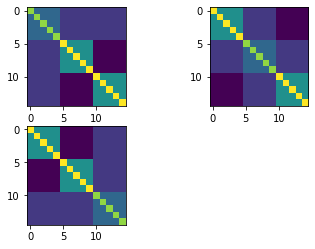

In [11]:
Z1 = X1 - X1.mean(axis=0) # Center the three design matrices 
Z2 = X2 - X2.mean(axis=0) 
Z3 = X3 - X3.mean(axis=0)

# Now calculate the assumed variance of the data: 
V1 = Z1 @ Z1.T + np.eye(15) # Both sigma's are 1, as lambda=1 
V2 = Z2 @ Z2.T + np.eye(15) # Both sigma's are 1, as lambda=1 
V3 = Z3 @ Z3.T + np.eye(15) # Both sigma's are 1, as lambda=1 
plt.subplot(2,2,1)
plt.imshow(V1)
plt.subplot(2,2,2)
plt.imshow(V2)
plt.subplot(2,2,3)
plt.imshow(V3)


As you can see, the two groups that are included in the dummy coding are assumed to have a negative covariance with each other.... 

Now what if don't want to assume this strange co-dependence structure in the data? Most reasonably, we would say that the observations in each group have the same variance, and within group share the smae covariance. 


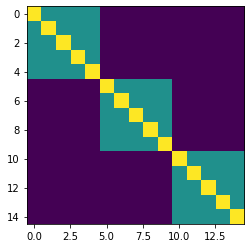

In [12]:
Z = X - X.mean(axis=0)
# Now calculate the assumed variance of the data: 
V = Z @ Z.T + np.eye(15) # Both sigma's are 1, as lambda=1 
plt.imshow(V)

## And how to fix it
If we don't want to assume a specific covariance structure between the group means, we need to conduct the ridge regression with a fully (redundantly) coded dummy variable.  

In [13]:
# So, to use this assumption, we need to conduct Ridge regression with the full dummy-coded design matrix. 
# Now we have 3 regressors, instead of two. To achieve a similar amount of shrinkage, we need to 
# therefor increase our Ridge coefficient a bit.   
R = Ridge(alpha = 3)
R.fit(X,D['y'])
ypred_R=R.predict(Xpred)
ypred_R

array([ 4.875,  8.   , 11.125])

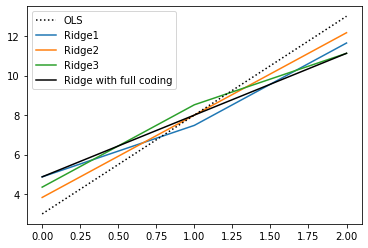

In [14]:
# As you can see, the Ridge regression does exactly the expected thing: 
# It shrinks the extreme groups towards the group mean - but doesn't shrink the 
# Group which has the mean on the group. 

h1 = plt.plot([0,1,2],np.c_[ypred_R1,ypred_R2,ypred_R3])
h2 = plt.plot([0,1,2],ypred_OLS,'k:')
h3 = plt.plot([0,1,2],ypred_R,'k-')
plt.legend(h2+h1+h3,('OLS','Ridge1','Ridge2','Ridge3','Ridge with full coding'))